In [1]:
import os
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read historical prices

In [2]:
df = pd.read_csv('PGE_SA.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Data'] = pd.to_datetime(df['Data'])
df = df.rename(columns={'Maks.':'Maks'})
df = df.rename(columns={'Min.':'Min'})
df.head()

,Data,Otwarcie,Zamknięcie,Maks,Min,Obrót (mln. zł),Zmiana (%)
0,2012-04-19,14.05,14.24,14.40,13.99,70.06,0.00
1,2012-04-20,14.24,14.35,14.42,14.20,39.45,0.75
2,2012-04-23,14.24,14.06,14.34,13.91,37.70,-2.01
3,2012-04-24,13.92,13.86,14.04,13.85,28.37,-1.40
4,2012-04-25,13.92,13.93,14.16,13.87,48.42,0.44


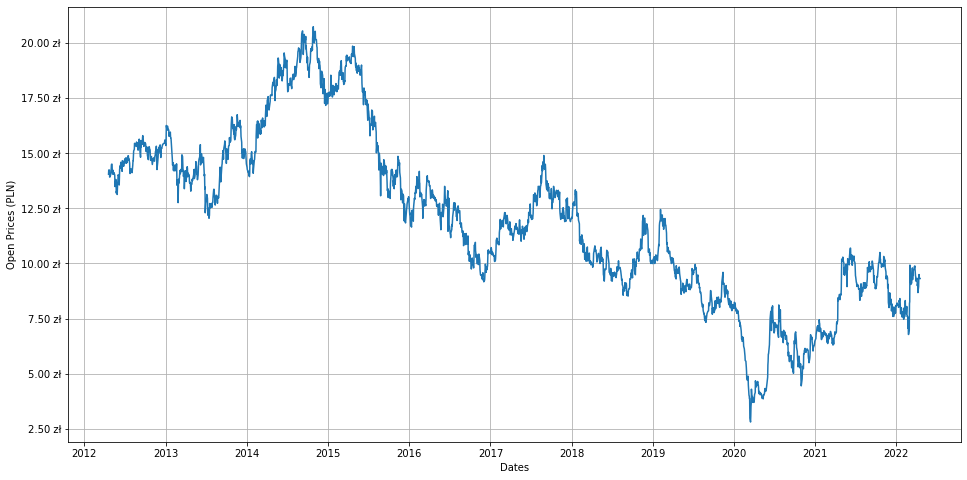

In [3]:
dateparse = lambda dates:pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('PGE_SA.csv', parse_dates=['Data'], index_col='Data', date_parser=dateparse)
data = data.sort_index(ascending=True)
plt.figure(figsize=(16, 8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices (PLN)')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f zł'))
plt.plot(data['Otwarcie'])

### OHLC Chart

In [4]:
fig = go.Figure(data=go.Ohlc(x=df.Data,
                open=df.Otwarcie,
                high=df.Maks,
                low=df.Min,
                close=df.Zamknięcie,
                name='Price'))
fig.update(layout_xaxis_rangeslider_visible=False)
fig.update_yaxes(ticksuffix="zł")

fig.show()

### Decomposition

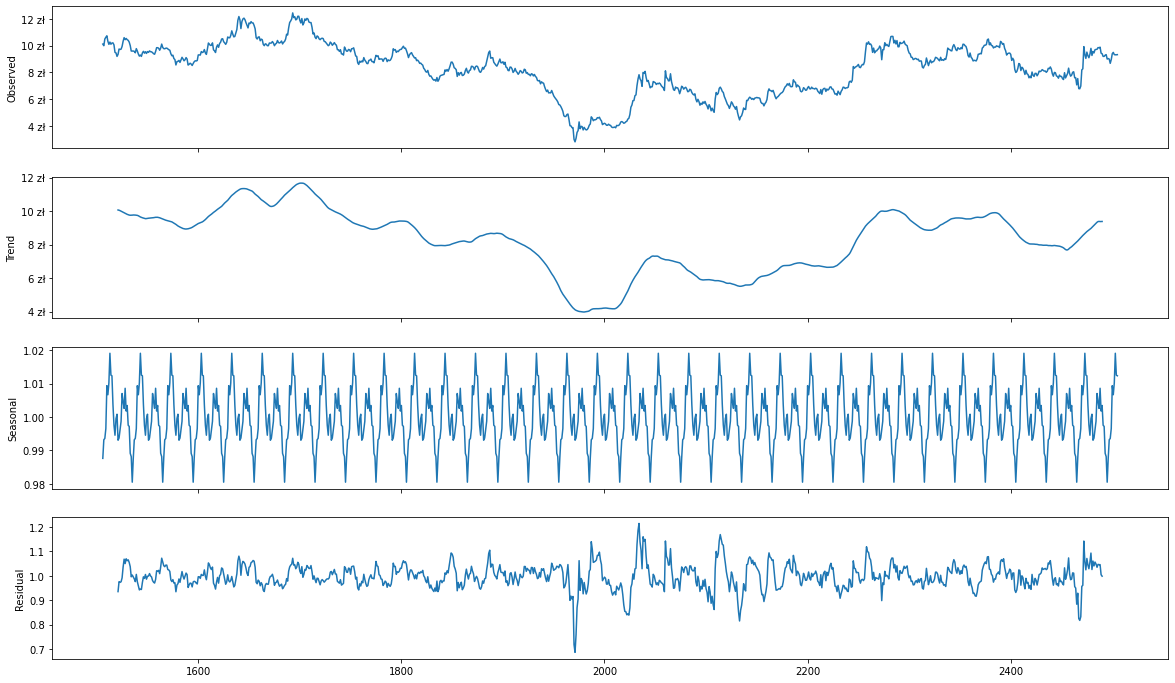

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
df_open = df['Otwarcie']
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_open[-1000:], model='multiplicative', freq=30)
fig, axs = plt.subplots(4, sharex=True, sharey=False, figsize=(20, 12))
axs[0].plot(result.observed)
axs[0].set_ylabel('Observed')
axs[0].set_yticks(np.arange(4,14,2))
axs[0].yaxis.set_major_formatter(mticker.FormatStrFormatter('%d zł'))
axs[1].plot(result.trend)
axs[1].set_ylabel('Trend')
axs[1].set_yticks(np.arange(4,14,2))
axs[1].yaxis.set_major_formatter(mticker.FormatStrFormatter('%d zł'))
axs[2].plot(result.seasonal)
axs[2].set_ylabel('Seasonal')
axs[3].plot(result.resid)
axs[3].set_ylabel('Residual')
plt.show()

### Plotting autocorrelation

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.840041
t+1  0.840041  1.000000


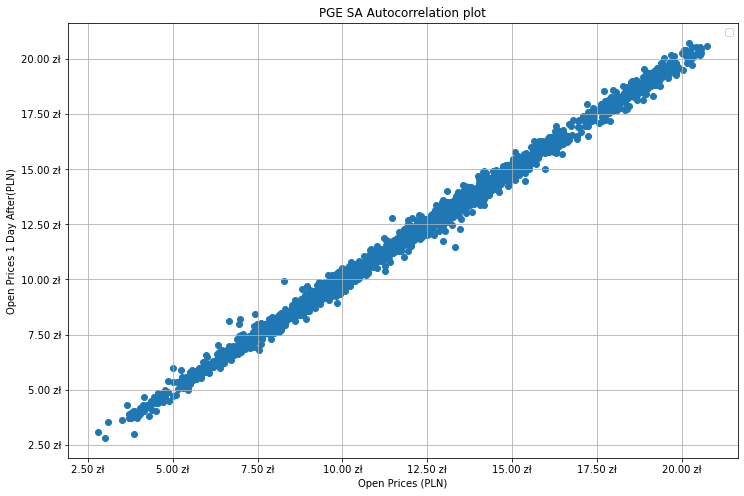

In [6]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12, 8))
lag_plot(df['Otwarcie'], lag=1)
plt.xlabel('Open Prices (PLN)')
plt.ylabel('Open Prices 1 Day After(PLN)')
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f zł'))
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f zł'))
plt.title('PGE SA Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(df['Otwarcie'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

### features

In [7]:
for label in ['Otwarcie', 'Zamknięcie', 'Maks', 'Min']:
    new_col = '{}_EMA_9'.format(label)
    df[new_col] = df[label].ewm(9).mean().shift()
    new_col = '{}_SMA_5'.format(label)
    df[new_col] = df[label].rolling(5).mean().shift()
    new_col = '{}_SMA_10'.format(label)
    df[new_col] = df[label].rolling(10).mean().shift()
    new_col = '{}_SMA_15'.format(label)
    df[new_col] = df[label].rolling(15).mean().shift()
    new_col = '{}_SMA_30'.format(label)
    df[new_col] = df[label].rolling(30).mean().shift()
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie_EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie_SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie_SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie_SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie, name='Otwarcie', opacity=0.2))
fig.update_yaxes(ticksuffix="zł")
fig.show()

#### RSI to predict whether a stock is overbought/oversold

In [8]:
def relative_strength_idx(df, n=14):
    open = df['Otwarcie']
    delta = open.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Data, y=df.RSI, name='RSI'))
fig.show()

### MACD

In [9]:
for label in ['Otwarcie', 'Zamknięcie', 'Maks', 'Min']:
    new_col = '{}_EMA_9'.format(label)
    df[new_col] = df[label].rolling(5).mean().shift()
    new_col = '{}_SMA_10'.format(label)
    df[new_col] = df[label].rolling(10).mean().shift()
    EMA_12 = pd.Series(df[label].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(df[label].ewm(span=26, min_periods=26).mean())
    new_col = '{}_MACD'.format(label)
    df[new_col] = pd.Series(EMA_12 - EMA_26)
    new_col1 = '{}_MACD_signal'.format(label)
    df[new_col1] = pd.Series(df[new_col].ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Min, name='Min'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Data, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Data, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.update_layout(
    yaxis=dict(ticksuffix="zł")
)

fig.add_trace(go.Scatter(x=df.Data, y=df['Min_MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Data, y=df['Min_MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

In [10]:
df['1day'] = df['Otwarcie'].shift(-1)

### Drop invalid samples

In [11]:
df = df.iloc[33:] 
df = df[:-30]
df.index = range(len(df))

### Split data

In [12]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Data, y=train_df.Otwarcie, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Data, y=test_df.Otwarcie, name='Test'))
fig.update_layout(
    yaxis=dict(ticksuffix="zł")
)
fig.update_layout(
    yaxis_title='Open Price (PLN)'
)
fig.show()

### Drop unnecessary columns

In [13]:
drop_cols = ['Data', 'Obrót (mln. zł)', 'Zmiana (%)']

train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

### Select best features

In [14]:
y_train = train_df['1day']
X_train = train_df.drop('1day',1)

y_test = test_df['1day']
X_test = test_df.drop('1day',1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Otwarcie                1955 non-null   float64
 1   Zamknięcie              1955 non-null   float64
 2   Maks                    1955 non-null   float64
 3   Min                     1955 non-null   float64
 4   Otwarcie_EMA_9          1955 non-null   float64
 5   Otwarcie_SMA_5          1955 non-null   float64
 6   Otwarcie_SMA_10         1955 non-null   float64
 7   Otwarcie_SMA_15         1955 non-null   float64
 8   Otwarcie_SMA_30         1955 non-null   float64
 9   Zamknięcie_EMA_9        1955 non-null   float64
 10  Zamknięcie_SMA_5        1955 non-null   float64
 11  Zamknięcie_SMA_10       1955 non-null   float64
 12  Zamknięcie_SMA_15       1955 non-null   float64
 13  Zamknięcie_SMA_30       1955 non-null   float64
 14  Maks_EMA_9              1955 non-null   

### Fine-tune XGBoostRegressor

In [15]:
parameters = {
    'n_estimators':[100, 200, 300, 400],
    'learning_rate':[0.001, 0.005, 0.01, 0.05],
    'max_depth':[8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state':[42]
}

tscv = TimeSeriesSplit(n_splits=3)
gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)

{'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42}


In [16]:
model = xgb.XGBRegressor(**grid_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

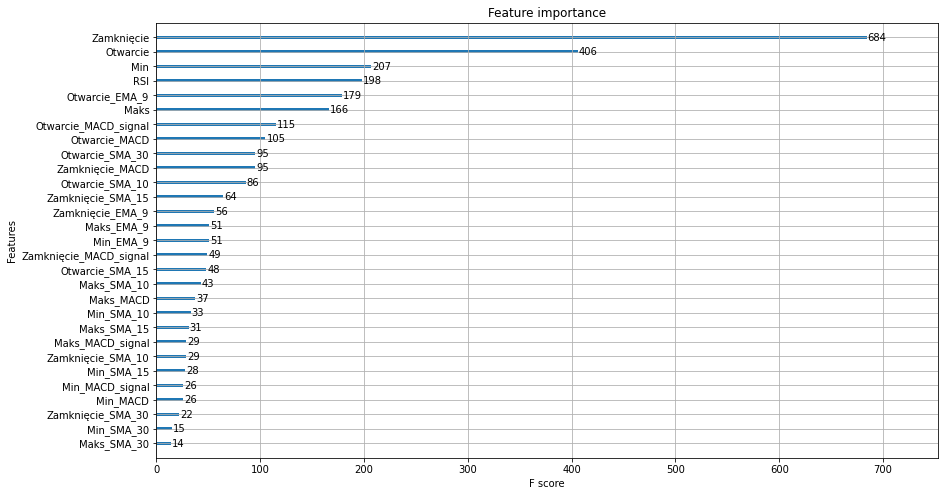

In [17]:
plot_importance(model)

### Fine-tune RandomForestRegressor

In [18]:
from sklearn.ensemble import RandomForestRegressor
param_grid={'bootstrap': [True],
 'max_depth': [20, 30, 40, 50, 60],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800]}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = tscv, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [19]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200)

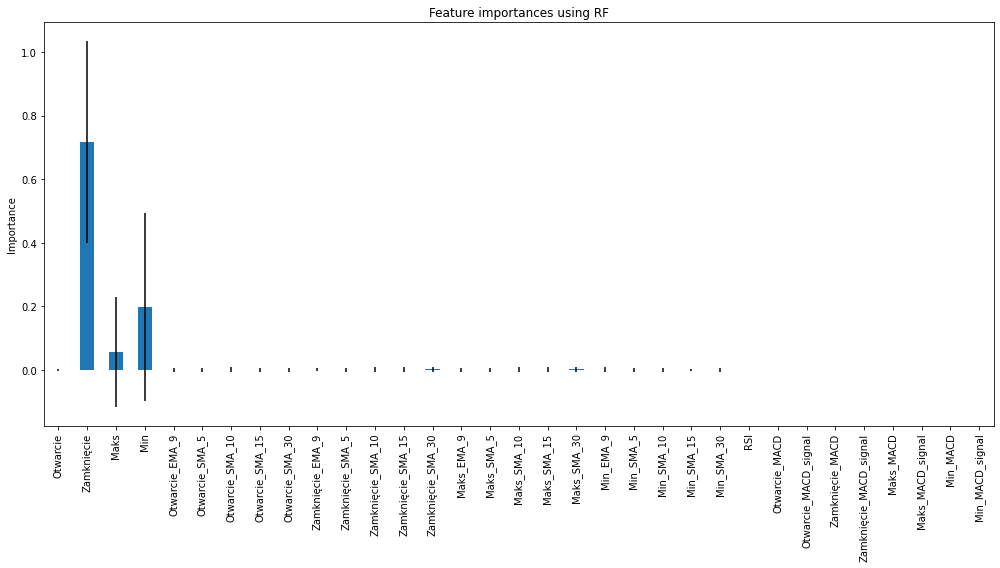

In [20]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using RF")
ax.set_ylabel("Importance")
fig.tight_layout()

### Fine-tune SVR Regressor

In [21]:
from sklearn.svm import SVR
param_grid={'kernel': ['rbf'],
 'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
 'C': [1, 10, 100, 1000, 10000]}
svr = SVR(epsilon = 0.01)
grid_search = GridSearchCV(estimator = svr, param_grid = param_grid, 
                          cv = tscv, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [22]:
model = grid_search.best_estimator_
model.fit(X_train, y_train)

SVR(C=1000, epsilon=0.01, gamma=0.0001)

Text(0.5, 0, 'Importance')

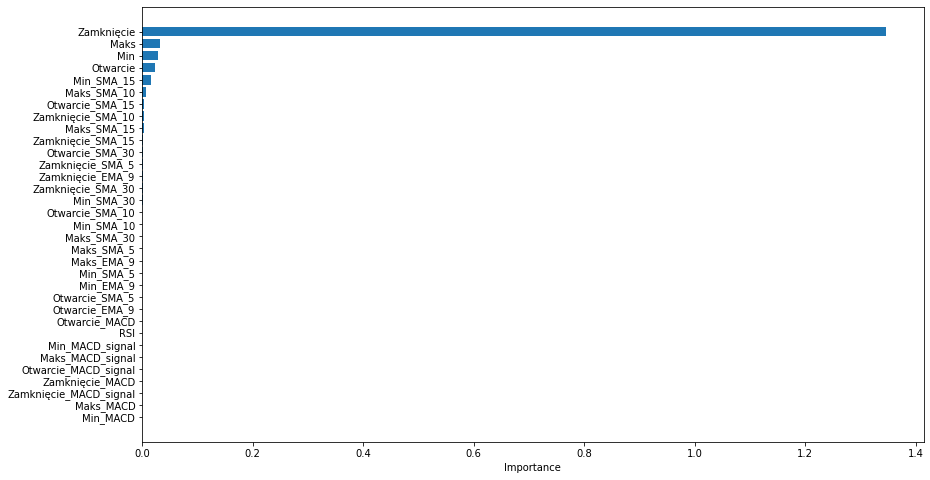

In [23]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model, X_train, y_train)

feature_names = X_train.columns.tolist()
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Importance")